In [ ]:
import os
import sys
import h5py
import pickle
import elephant
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
import seaborn as sns
import quantities as pq
import tensorflow as tf
import matplotlib.pyplot as plt
from oasis.functions import deconvolve
from oasis.oasis_methods import oasisAR1, oasisAR2
from multiprocessing import Pool

from gan.utils import h5_helper
from gan.utils import spike_helper
from neo.core import SpikeTrain
from elephant.spike_train_dissimilarity import van_rossum_dist

%matplotlib inline

plt.style.use('seaborn-deep')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('TensorFlow version {}'.format(tf.__version__))

filename = 'dataset/raw_data/ST260_Day4_signals4Bryan.pkl'

TensorFlow version 2.3.0


In [ ]:
with open(filename, 'rb') as file:
 data = pickle.load(file)

print(data.keys())

signals = data['signals'][2:]
spikes = data['spikes'][2:]
oasis = data['oasis'][2:]

print('signals shape {}'.format(signals.shape))
print('spikes shape {}'.format(spikes.shape))
print('time shape {}'.format(data['time'].shape))

print('min signal: {}'.format(np.min(signals)))
print('max signal: {}'.format(np.max(signals)))
print('avg signal: {}\n'.format(np.mean(signals)))

print('min spike: {}'.format(np.min(spikes)))
print('max spike: {}'.format(np.max(spikes)))
print('avg spike: {}\n'.format(np.mean(spikes)))

print('min oasis: {}'.format(np.min(oasis)))
print('max oasis: {}'.format(np.max(oasis)))
print('avg oasis: {}'.format(np.mean(oasis)))

dict_keys(['signals', 'spikes', 'position', 'trial', 'time', 'oasis'])
signals shape (102, 21556)
spikes shape (102, 21556)
time shape (21556,)
min signal: -0.528456643217992
max signal: 9.794446323517322
avg signal: 0.2887301802220373

min spike: 0
max spike: 5
avg spike: 0.03888412852615531

min oasis: 0.0
max oasis: 1.0
avg oasis: 0.008309409953653812


In [ ]:
def normalize(x):
  x_min, x_max = np.min(x), np.max(x)
  new_x = (x - x_min) / (x_max - x_min)
  return new_x, x_min, x_max

def denormalize(x, x_min, x_max):
  original_x = x * (x_max - x_min) + x_min
  return original_x

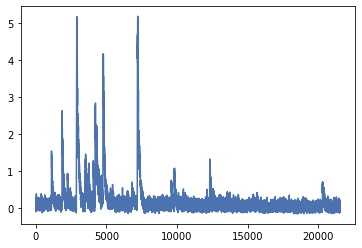

In [ ]:
index = 50
plt.plot(signals[index])

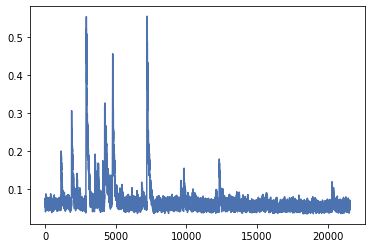

In [ ]:
new_signals, signals_min, signals_max = normalize(signals)
plt.plot(new_signals[index])

True


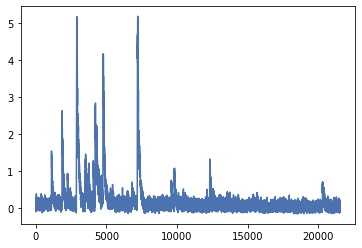

In [ ]:
original_signals = denormalize(new_signals, signals_min, signals_max)
plt.plot(original_signals[index])
print(np.allclose(signals, original_signals))

In [ ]:
def plot_signal(trace1, trace2):
  assert len(trace1) == len(trace2)

  plt.figure(figsize=(20, 2))
  plt.plot(trace1, label='signal', alpha=0.6, color='dodgerblue')

  x = np.nonzero(trace2)[0]
  y = np.zeros(x.shape)
  plt.scatter(x, y, s=200, marker='|', label='spike', color='orangered')
  plt.legend(ncol=3, frameon=False, loc=(.04, .85))
  plt.title('Neuron #{:03d}'.format(5))
  plt.xlabel('Time (ms)')
  axis = plt.gca()
  axis.spines['top'].set_visible(False)
  axis.spines['right'].set_visible(False)
  axis.get_xaxis().tick_bottom()
  axis.get_yaxis().tick_left()
  plt.tight_layout()

In [ ]:
def plot_signals(traces, filename=None):
  rows = len(traces)
  plt.figure(figsize=(15, int(2 * rows)))

  for i in range(rows):
    plt.subplot(rows, 1, i + 1)
    plt.plot(traces[i], linewidth=2, alpha=0.8, color='black')
    axis = plt.gca()
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    if i < rows - 1:
      axis.spines['bottom'].set_visible(False)
      axis.get_xaxis().set_visible(False)
    plt.tight_layout()

  plt.tight_layout()
  if filename is not None:
    plt.savefig(filename, dpi=120, transparent=True)

In [ ]:
def plot_spikes(spikes, filename=None):
  rows = len(spikes)
  plt.figure(figsize=(15, int(0.8 * rows)))

  for i in range(rows):
    plt.subplot(rows, 1, i + 1)
    x = np.nonzero(spikes[i])[0]
    y = np.zeros(x.shape)
    plt.scatter(x, y, s=80, marker='|', label='spike', color='black')
    axis = plt.gca()
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.get_yaxis().set_visible(False)
    if i < rows - 1:
      axis.spines['bottom'].set_visible(False)
      axis.get_xaxis().set_visible(False)
  
    plt.tight_layout()

  plt.tight_layout()
  if filename is not None:
    plt.savefig(filename, dpi=120, transparent=True)

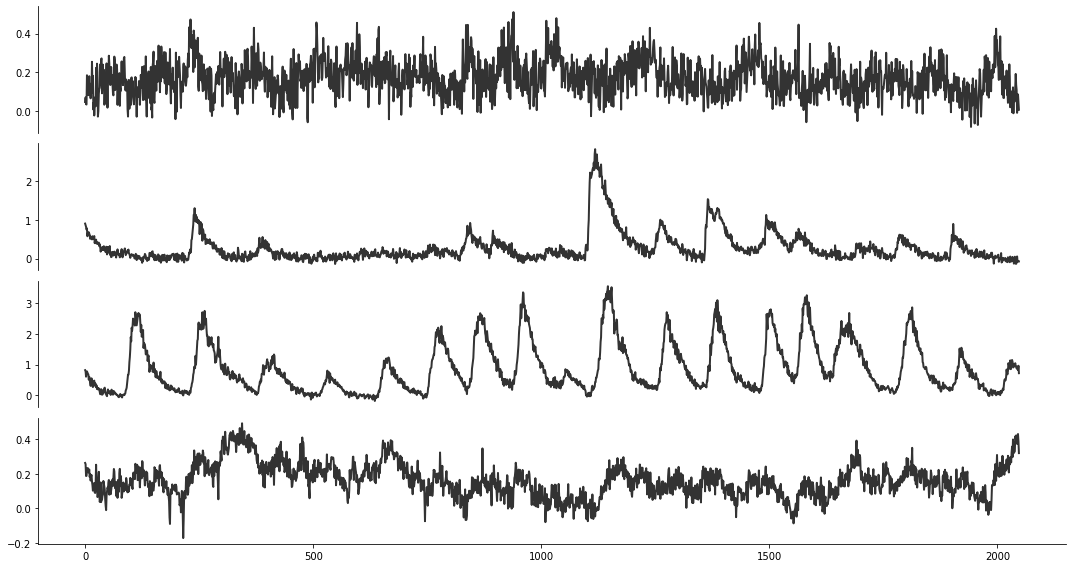

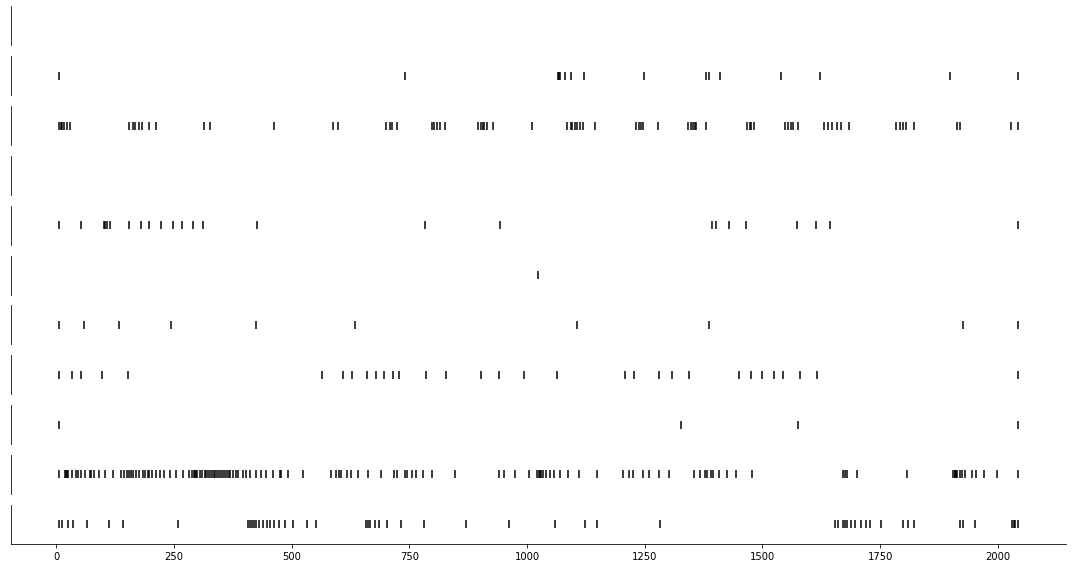

In [ ]:
plot_signals([signals[i][5192:7240] for i in range(4, 8)])
plt.show()
plt.close()

plot_spikes([oasis[i][5192:7240] for i in range(4, 15)])
plt.show()
plt.close()

In [ ]:
generated = 'runs/wavegan/004_wavegan_units64_kl24_strides2_ps10_leakyrelu_nd32_layernorm/generated/epoch399_signals.h5'

fake_signals = h5_helper.get(generated, name='signals')
fake_spikes = h5_helper.get(generated, 'spikes')
print(fake_signals.shape, fake_spikes.shape)

(1000, 2048, 102) (1000, 2048, 102)


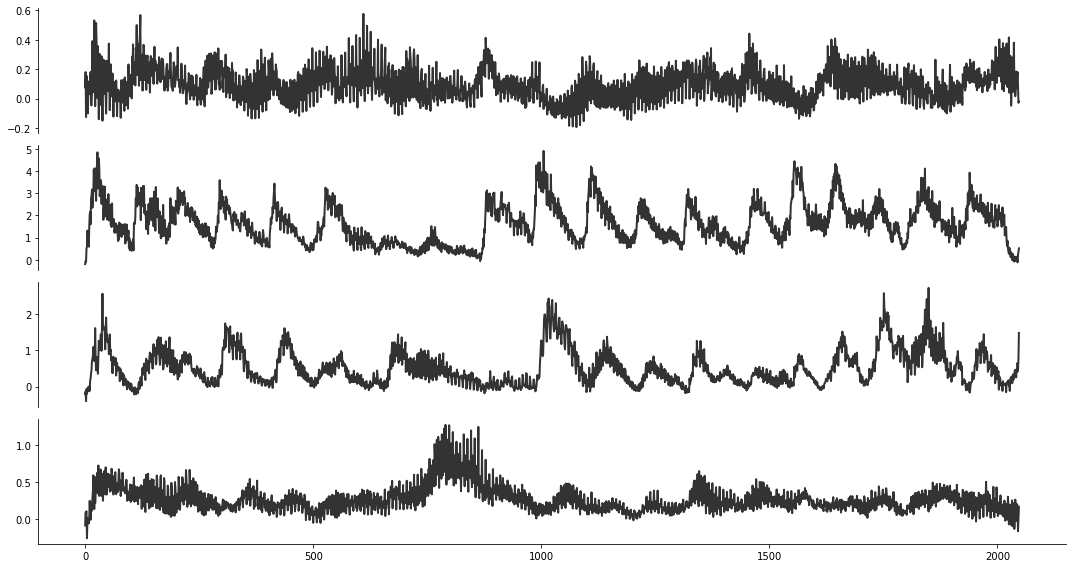

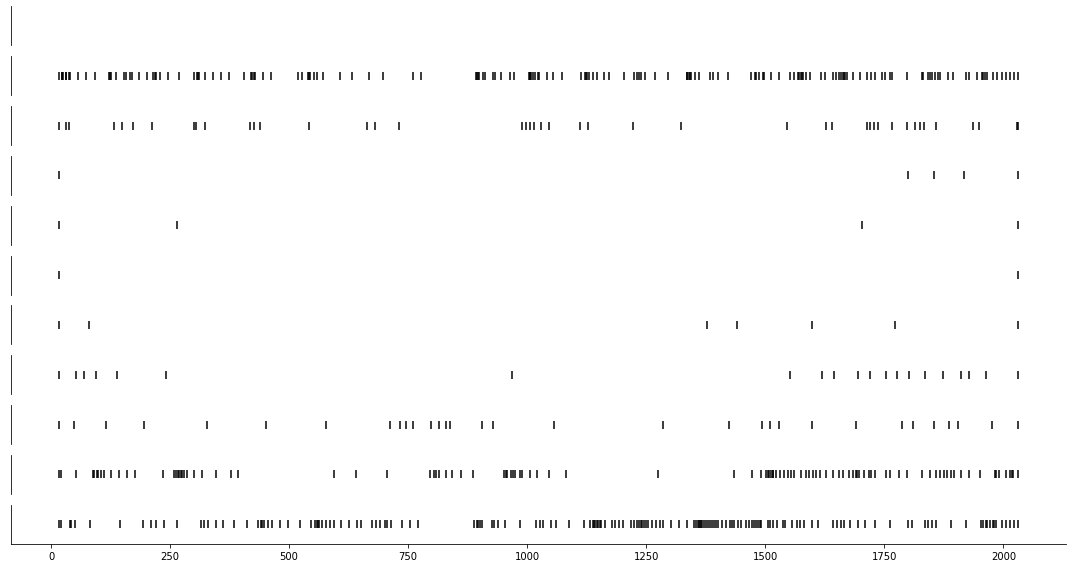

In [ ]:
plot_signals([fake_signals[0, :, i] for i in range(4, 8)], filename='generated_traces.png')
plt.show()
plt.close()

plot_spikes([fake_spikes[0, :, i] for i in range(4, 15)], filename='generated_spikes.png')
plt.show()
plt.close()

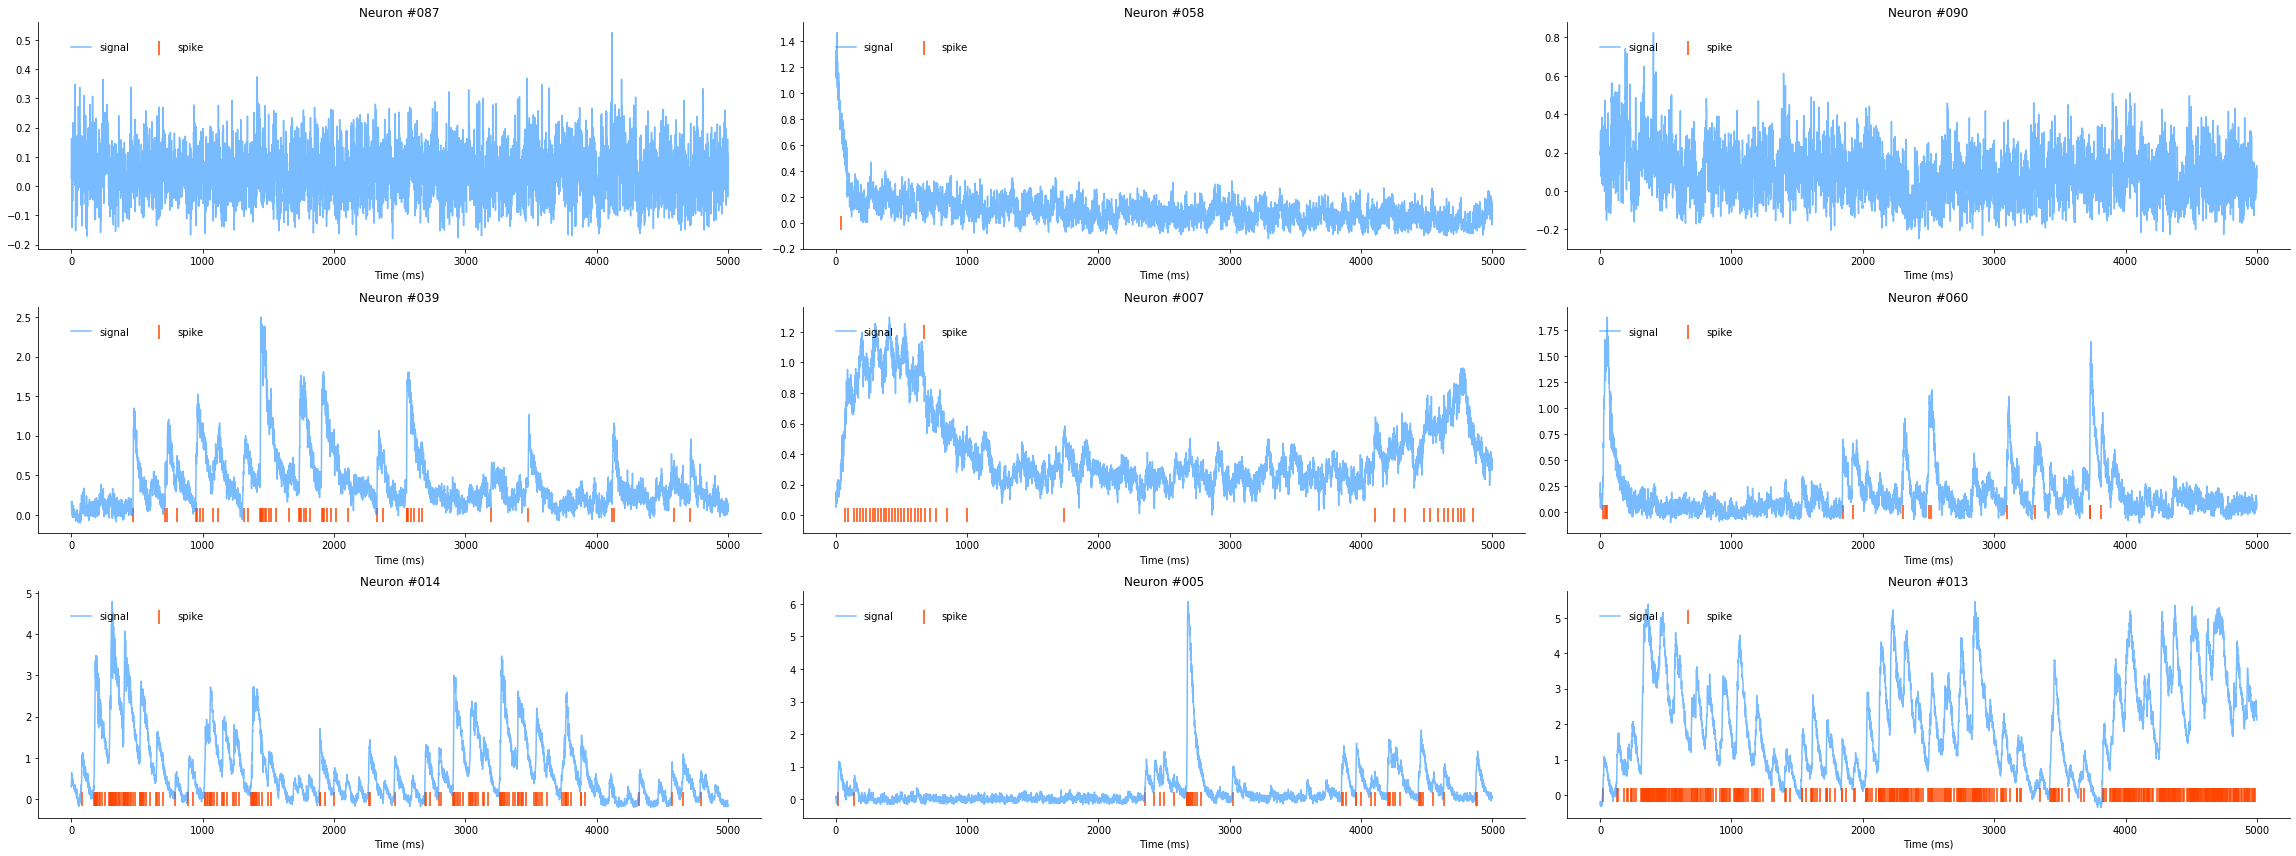

In [ ]:
with open(filename, 'rb') as file:
 data = pickle.load(file)

signals = data['signals'][2:]
spikes = data['oasis'][2:]


neurons = [87, 58, 90, 39, 7, 60, 14, 5, 13]
num_rows, rem = divmod(len(neurons), 3)
if rem > 0:
  num_rows += 1

fig = plt.figure(figsize=(32, 4 * num_rows))
fig.patch.set_facecolor('white')

for i, neuron in enumerate(neurons):
  signal, spike = signals[neuron][:5000], spikes[neuron][:5000]
  plt.subplot(num_rows, 3, i + 1)
  plt.plot(signal, label='signal', alpha=0.6, color='dodgerblue')

  x = np.nonzero(spike)[0]
  y = np.zeros(x.shape)
  plt.scatter(x, y, s=200, marker='|', label='spike', color='orangered')
  plt.legend(ncol=3, frameon=False, loc=(.04, .85))
  plt.title('Neuron #{:03d}'.format(neuron))
  plt.xlabel('Time (ms)')
  axis = plt.gca()
  axis.spines['top'].set_visible(False)
  axis.spines['right'].set_visible(False)
  axis.get_xaxis().tick_bottom()
  axis.get_yaxis().tick_left()

plt.tight_layout()

plt.show()
plt.close()

In [ ]:
_, oasis_spike, _, _, _ = deconvolve(signal, g=(None, None), penalty=1)
plot_signal(signal, spike, oasis_spike)

TypeError: ignored

In [ ]:
_, oasis_spike = oasisAR1(signal, g=0.95, s_min=.55)
oasis_spike = np.where(oasis_spike > 0.5, 1, 0)

plot_signal(signal, spike, oasis_spike)

In [ ]:
with open(filename, 'rb') as file:
 data = pickle.load(file)

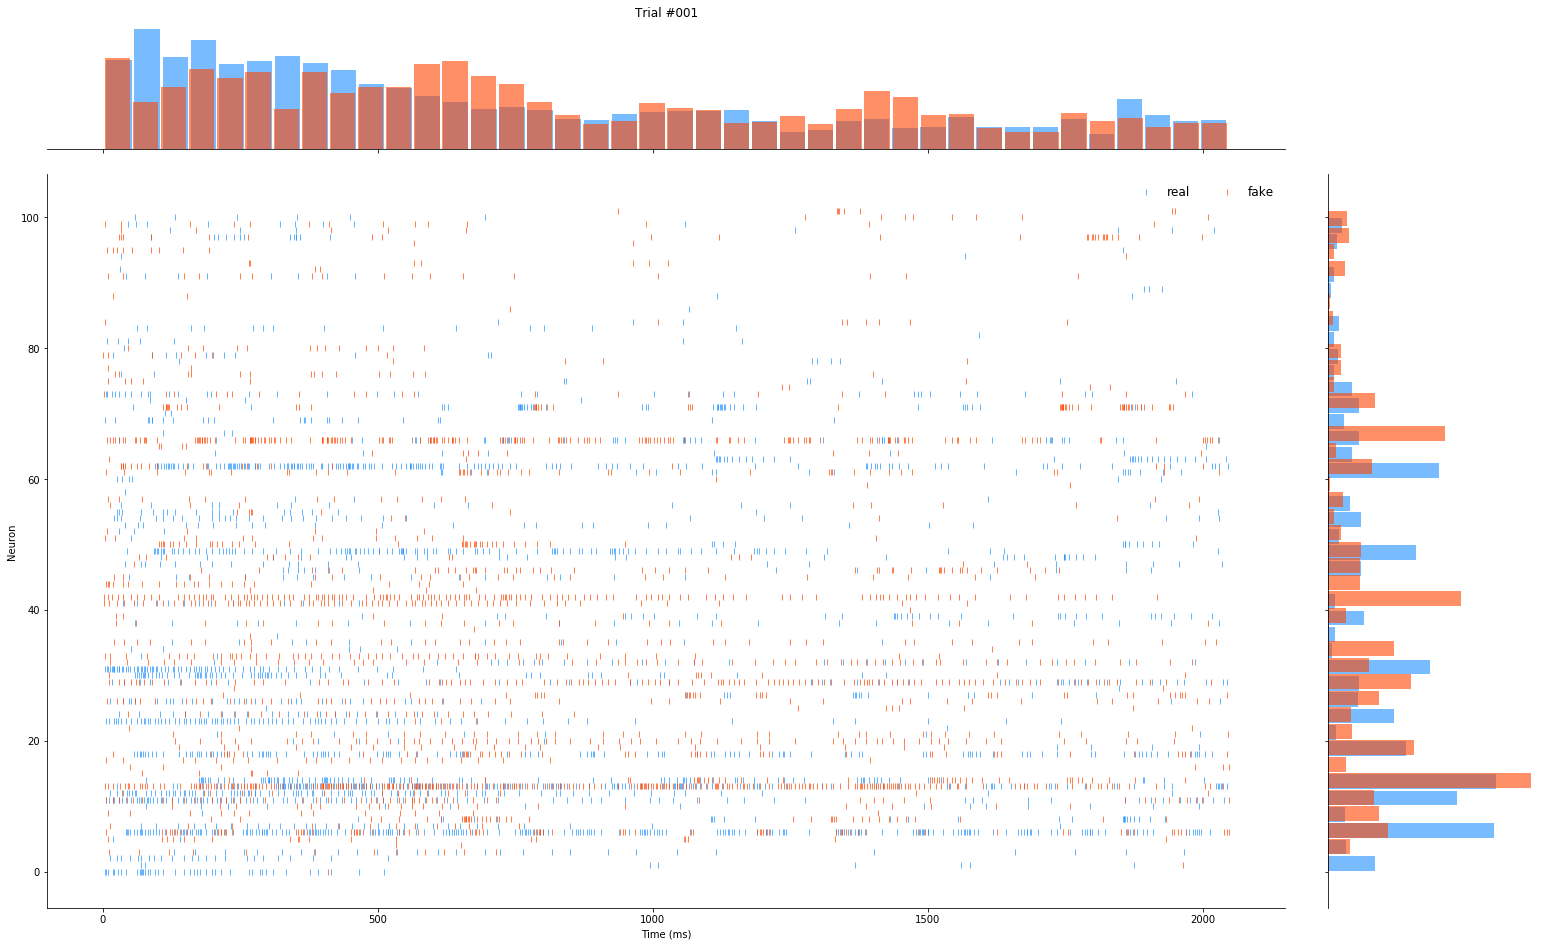

In [ ]:
spikes = data['oasis'][2:]

spike1_x, spike1_y = np.nonzero(spikes[:, :2048])
spike2_x, spike2_y = np.nonzero(spikes[:, 4096:6144])
real_data = [True] * len(spike1_y) + [False] * len(spike2_y)

x = np.concatenate([spike1_x, spike2_x])
y = np.concatenate([spike1_y, spike2_y])
df = pd.DataFrame({'x': y, 'y': x, 'real_data': real_data})

g = sns.JointGrid(x='x', y='y', data=df)
plt.gcf().set_size_inches(24,14)
plt.gcf().set_facecolor("white")

real = df.loc[df.real_data == True]
fake = df.loc[df.real_data == False]

sns.scatterplot(real.x, real.y, marker='|', color='dodgerblue', alpha=0.9, ax=g.ax_joint)
ax = sns.scatterplot(fake.x, fake.y, marker='|', color='orangered', alpha=0.9, ax=g.ax_joint)
ax.set(xlabel='Time (ms)', ylabel='Neuron')

hist_kws={"rwidth": 0.9, "alpha": 0.6}

sns.distplot(real.x, kde=False, hist_kws=hist_kws, color="dodgerblue", ax=g.ax_marg_x, bins=40)
ax = sns.distplot(fake.x, kde=False, hist_kws=hist_kws, color="orangered", ax=g.ax_marg_x , bins=40)
ax.set(xlabel='', ylabel='', title='Trial #001')

sns.distplot(real.y, kde=False, hist_kws=hist_kws, color="dodgerblue", ax=g.ax_marg_y, bins=40, vertical=True)
ax = sns.distplot(fake.y, kde=False, hist_kws=hist_kws, color="orangered", ax=g.ax_marg_y, bins=40, vertical=True)
ax.set_ylabel('')

g.ax_joint.legend(labels=['real', 'fake'], ncol=2, frameon=False, prop={'weight':'regular', 'size':12}, loc='upper right')

plt.show()
plt.close()

In [ ]:
class HParams(object):
  def __init__(self):
    self.num_neurons = 102

In [ ]:
saved_file = 'epoch199_signals.h5'

hparams = HParams()

In [ ]:
def train_to_neo(train, t_stop=None):
  ''' convert a single spike train to Neo SpikeTrain in sec scale '''
  return SpikeTrain(
      np.nonzero(train)[0] * pq.ms,
      units=pq.s,
      t_stop=train.shape[-1] * pq.ms if t_stop is None else t_stop,
      dtype=np.float32)


def trains_to_neo(trains):
  ''' convert array of spike trains to list of  Neo SpikeTrains in sec scale '''
  assert trains.ndim == 2
  t_stop = trains.shape[-1] * pq.ms
  return [train_to_neo(trains[i], t_stop=t_stop) for i in range(len(trains))]


def oasis_function(signal, threshold=0.5):
  ''' apply OASIS function to a single calcium signal and binarize spike train 
  with threshold '''
  # if signal.dtype != np.double:
  #   signal = signal.astype(np.double)
  _, train = oasisAR1(signal, g=0.95, s_min=.55)
  return np.where(train > threshold, 1.0, 0.0)


def deconvolve_signals(signals, threshold=0.5, to_neo=False):
  ''' apply OASIS function to array of signals and convert to Neo SpikeTrain 
  if to_neo is True'''
  if tf.is_tensor(signals):
    signals = signals.numpy()
  
  assert signals.ndim == 2

  if signals.dtype != np.double:
    signals = signals.astype(np.double)

  spike_trains = []
  t_stop = signals.shape[-1] * pq.ms

  for i in range(len(signals)):
    spike_train = oasis_function(signals[i], threshold=threshold)
    spike_trains.append(
        train_to_neo(spike_train, t_stop=t_stop) if to_neo else spike_train)

  if not to_neo:
    spike_trains = np.array(spike_trains, dtype=np.float32)

  return spike_trains

In [ ]:
real_spikes = h5_helper.get(saved_file, name='real_spikes', index=0, neuron=True, hparams=hparams)
print('real_spikes.shape {}'.format(real_spikes.shape))
real_spikes = trains_to_neo(real_spikes)

fake_signals = h5_helper.get(saved_file, 'fake_signals', index=0, neuron=True, hparams=hparams)
print('fake_signals.shape {}'.format(fake_signals.shape))
fake_spikes = deconvolve_signals(fake_signals, to_neo=True)

assert len(real_spikes) == len(fake_spikes)

NameError: ignored

In [ ]:
oasis = data['oasis'][2:]
print(oasis.shape)

neo_spikes = trains_to_neo(oasis)
print(len(neo_spikes))

(102, 21556)
102


In [ ]:
mean_firing_rate = [elephant.statistics.mean_firing_rate(neo_spike) for neo_spike in neo_spikes]
mean_firing_rate = np.array(mean_firing_rate * pq.s, dtype=np.float32)

[2.2731490e+00 1.8556318e+00 7.3297458e+00 2.3195398e+00 2.7834478e-01
 6.6895531e+01 4.3236221e+01 2.6442754e+00 5.1493783e+00 2.9690111e+00
 4.4071255e+00 3.1313787e+01 2.4587122e+01 7.5895340e+01 5.5390610e+01
 1.3917239e+00 5.6596770e+00 2.5514939e+00 3.6648727e+01 2.1339767e+00
 5.5205050e+00 6.1699758e+00 7.4225277e-01 4.7318611e+00 3.4329190e+00
 2.0875859e+00 2.8112823e+01 2.7416962e+01 3.0617926e+00 2.6210800e+01
 1.1133791e+01 4.2215624e+00 1.2386343e+01 7.6080909e+00 7.8864354e-01
 1.2757469e+01 2.7834478e-01 3.7112638e-01 1.1551309e+01 2.5978847e+00
 5.7988496e+00 4.2401188e+01 3.5720913e+01 2.3195398e-01 4.0823903e+00
 1.0020412e+01 4.9638152e+00 2.5051031e+00 2.3195398e+00 5.9844127e+00
 5.5205050e+00 1.9484135e+00 5.5668956e-01 1.1133791e+00 3.6184821e+00
 3.3401372e+00 3.8504362e+00 2.1339767e+00 4.6390798e-02 4.9638152e+00
 2.9226203e+00 8.9534235e+00 3.4793098e+01 4.0823903e+00 1.1133791e+00
 6.9586194e-01 3.1035442e+01 5.5668956e-01 3.2473558e-01 1.5772871e+00
 1.855

## Metrics


In [ ]:
from gan.utils.spike_metrics import mean_firing_rate

real_spikes = h5_helper.get('runs/wavegan/004_wavegan_units64_kl24_strides2_ps10_leakyrelu_nd32_layernorm/generated/validation.h5', 'spikes', neuron=27)
real_spikes = spike_helper.trains_to_neo(real_spikes)

fake_spikes = h5_helper.get('runs/wavegan/004_wavegan_units64_kl24_strides2_ps10_leakyrelu_nd32_layernorm/generated/epoch399_signals.h5', 'spikes', neuron=27)
fake_spikes = spike_helper.trains_to_neo(fake_spikes)

assert len(real_spikes) == len(fake_spikes)

real_firing_rate = mean_firing_rate(real_spikes)
fake_firing_rate = mean_firing_rate(fake_spikes)
print(real_firing_rate)

[1.0078125  0.7265625  0.62109375 0.6796875  1.2890625  0.29296875
 0.59765625 0.515625   0.703125   0.85546875 0.6328125  0.71484375
 0.97265625 0.5625     0.65625    0.41015625 0.33984375 0.3515625
 0.64453125 0.421875   0.31640625 0.3046875  0.5625     0.59765625
 0.71484375 0.75       0.69140625 1.0429688  0.6328125  0.57421875
 0.66796875 0.4921875  0.66796875 1.0664062  0.64453125 0.66796875
 0.64453125 0.6328125  0.6796875  0.703125   0.55078125 0.5859375
 0.5390625  1.1015625  0.6328125  0.65625    0.5859375  0.5625
 1.3007812  0.5859375  0.28125    0.4921875  0.94921875 0.69140625
 0.46875    0.65625    0.64453125 0.50390625 0.6328125  0.7265625
 0.8203125  0.7265625  1.2539062  0.4921875  0.50390625 0.52734375
 0.87890625 0.5390625  0.57421875 1.0898438  1.1015625  0.71484375
 0.17578125 0.57421875 0.75       1.0078125  0.5390625  0.64453125
 0.38671875 0.38671875 0.4921875  0.3046875  0.64453125 0.50390625
 1.265625   0.55078125 0.421875   0.55078125 0.2578125  0.59765625
 0

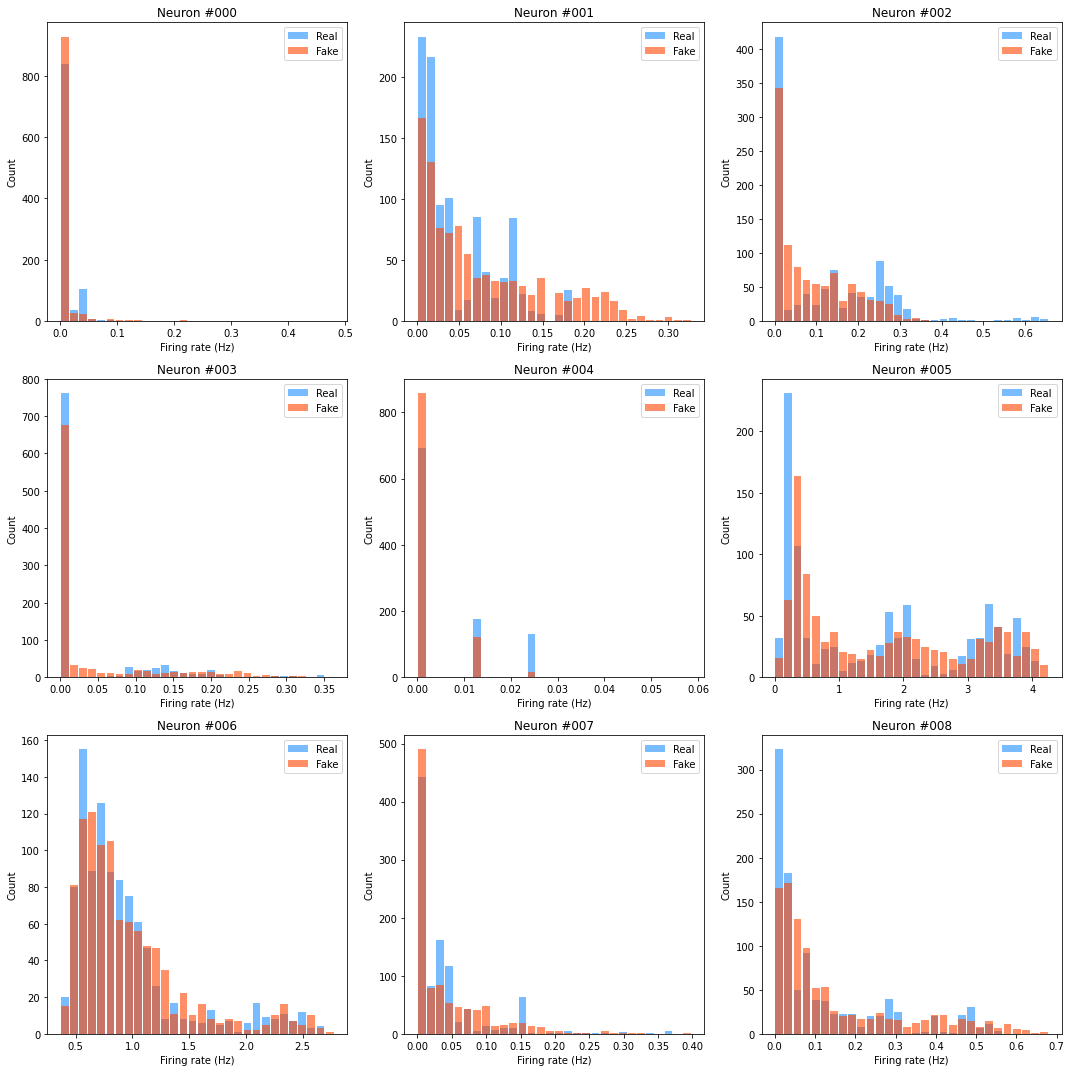

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))

neuron, i, j, = 0, 0, 0
while neuron < 9:
  real_spikes = h5_helper.get('runs/wavegan/004_wavegan_units64_kl24_strides2_ps10_leakyrelu_nd32_layernorm/generated/validation.h5', 'spikes', neuron=neuron)
  real_spikes = spike_helper.trains_to_neo(real_spikes)

  fake_spikes = h5_helper.get('runs/wavegan/004_wavegan_units64_kl24_strides2_ps10_leakyrelu_nd32_layernorm/generated/epoch399_signals.h5', 'spikes', neuron=neuron)
  fake_spikes = spike_helper.trains_to_neo(fake_spikes)

  real_firing_rate = mean_firing_rate(real_spikes)
  fake_firing_rate = mean_firing_rate(fake_spikes)
  
  hist_kws={"rwidth": 0.85, "alpha": 0.6, "range": [min(min(real_firing_rate), min(fake_firing_rate)), max(max(real_firing_rate), max(fake_firing_rate))]}

  sns.distplot(real_firing_rate, bins=30, kde=False, hist_kws=hist_kws, color="dodgerblue", label="Real", ax=axes[i, j])
  ax = sns.distplot(fake_firing_rate, bins=30, kde=False, hist_kws=hist_kws, color="orangered", label="Fake", ax=axes[i, j])

  ax.set(xlabel='Firing rate (Hz)', ylabel='Count', title='Neuron #{:03d}'.format(neuron))
  ax.legend()

  j += 1
  if j == 3:
    i += 1
    j = 0
  neuron += 1

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
import pandas as pd
from gan.utils.spike_metrics import mean_firing_rate

def kl_divergence(p, q):
  return np.sum(np.where(np.logical_or(np.equal(p, 0), np.equal(q, 0)), 0, p * np.log(p / q)))

kl, num_neurons = [], 102
for neuron in range(num_neurons):
  real_spikes = h5_helper.get('runs/pycharm/generated/validation.h5', 'spikes', neuron=neuron)
  real_spikes = trains_to_neo(real_spikes)

  fake_spikes = h5_helper.get('runs/pycharm/generated/epoch019_signals.h5', 'spikes', neuron=neuron)
  fake_spikes = trains_to_neo(fake_spikes)

  assert len(real_spikes) == len(fake_spikes)

  real_firing_rate = mean_firing_rate(real_spikes)
  fake_firing_rate = mean_firing_rate(fake_spikes)

  assert real_firing_rate.shape == fake_firing_rate.shape

  df = pd.DataFrame({
    'firing_rate': np.concatenate([real_firing_rate, fake_firing_rate]), 
    'real_data': [True] * len(real_firing_rate) + [False] * len(fake_firing_rate)
  })

  num_bins = 30
  df['bins'] = pd.cut(df.firing_rate, bins=num_bins, labels=np.arange(num_bins))

  real_pdf = np.array([len(df[(df.bins == i) & (df.real_data == True)]) for i in range(num_bins)], dtype=np.float32)  / len(real_firing_rate)
  fake_pdf = np.array([len(df[(df.bins == i) & (df.real_data == False)]) for i in range(num_bins)], dtype=np.float32) / len(fake_firing_rate)

  kl.append(kl_divergence(real_pdf, fake_pdf))

/Users/bryanlimy/miniconda3/envs/calciumgan/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/bryanlimy/miniconda3/envs/calciumgan/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/Users/bryanlimy/miniconda3/envs/calciumgan/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/bryanlimy/miniconda3/envs/calciumgan/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


KeyboardInterrupt: ignored

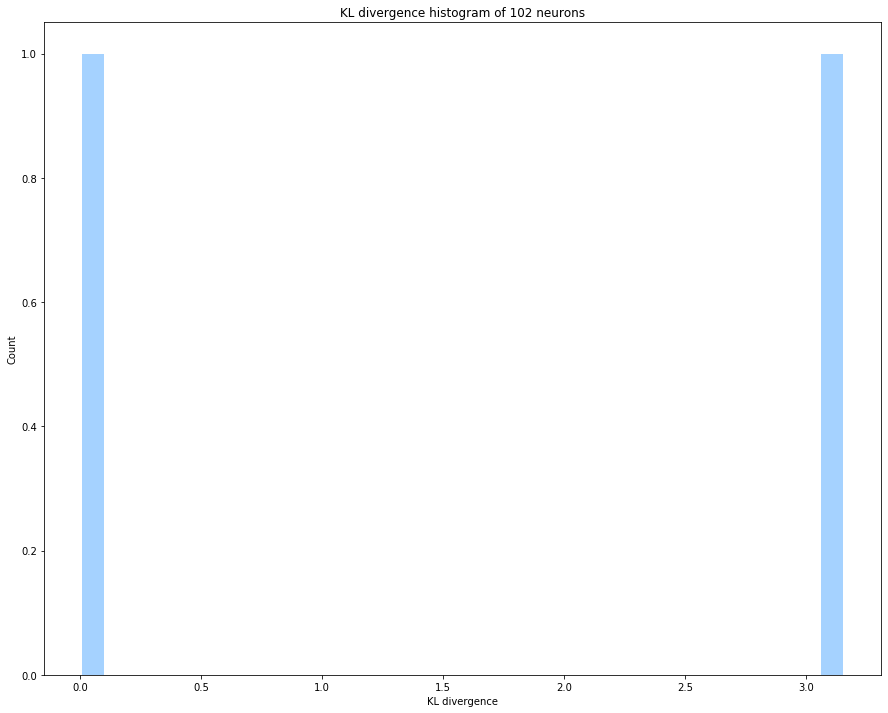

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')

ax = sns.distplot(kl, kde=False, hist_kws={"rwidth": 0.85}, color="dodgerblue", bins=30)
ax.set(xlabel='KL divergence', ylabel='Count', title='KL divergence histogram of {} neurons'.format(102))
plt.show()
plt.close()

## Fast Fourier transform

In [ ]:
import scipy

with open('dataset/raw_data/ST260_Day4_signals4Bryan.pkl', 'rb') as file:
 data = pickle.load(file)

signals = data['signals'][2:]
spikes = data['oasis'][2:]

print(signals.shape, spikes.shape)

(102, 21556) (102, 21556)


(2048,)


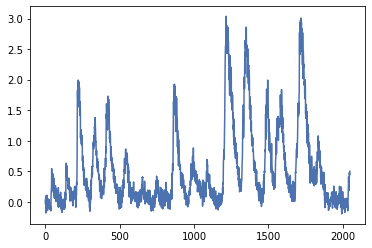

In [ ]:
signal, spike = signals[27, 2048:4096], spikes[27, 2048:4096]
print(signal.shape)
plt.plot(signal)

In [ ]:
def normalize(x, x_min, x_max):
  new_x = (x - x_min) / (x_max - x_min)
  return new_x

def denormalize(x, x_min, x_max):
  original_x = x * (x_max - x_min) + x_min
  return original_x

In [ ]:
def plot_fft(sample, sample_rate, color='dodgerblue', filename=None):
  tick_size = 18
  label_size = 22
  plt.rc('xtick', labelsize=tick_size)
  plt.rc('ytick', labelsize=tick_size)
  plt.rc('axes', titlesize=label_size)
  plt.rc('axes', labelsize=label_size)
  plt.rc('axes', labelsize=label_size)

  fig = plt.figure(figsize=(8, 7))
  fig.patch.set_facecolor('white')

  # plot signal
  plt.subplot(2, 1, 1)
  plt.plot(sample, alpha=0.7, color=color, linewidth=2)
  axis = plt.gca()
  axis.spines['top'].set_visible(False)
  axis.spines['right'].set_visible(False)
  plt.xlabel('Time (s)')
  time = np.arange(0, len(signal), 200)
  plt.xticks(ticks=time, labels=time // sample_rate)

  plt.tight_layout()

  # plot frequency
  n = len(sample)
  T = 1/sample_rate
  yf = np.fft.fft(signal.astype(np.complex64))
  xf = np.linspace(0.0, 1.0/(2.0 * T), n//2)

  plt.subplot(2, 1, 2)
  plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), alpha=0.7, color=color, linewidth=2)
  
  axis = plt.gca()
  axis.spines['top'].set_visible(False)
  axis.spines['right'].set_visible(False)
  plt.yscale('log')
  plt.ylabel('Log magnitude')
  plt.xlabel('Frequency (Hz)')

  plt.tight_layout()
  if filename is not None:
    plt.savefig(filename, dpi=200, transparent=True)


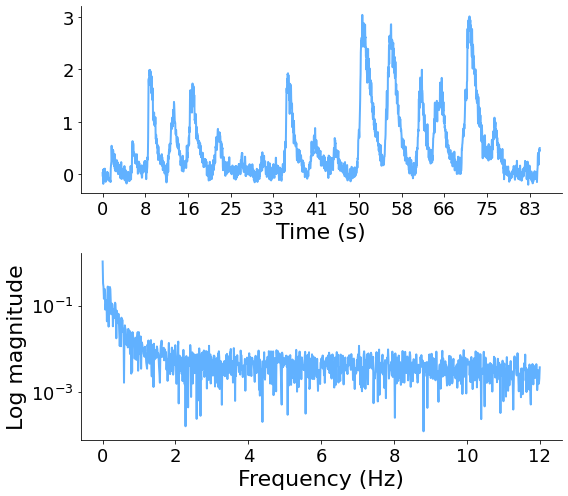

In [ ]:
plot_fft(
    signal,
    sample_rate=24,
    filename='diagrams/real_fft.png'
)
plt.show()
plt.close()

In [ ]:
generated = 'runs/conv2d/023_conv2d_fft_wavegan_kernel_size_25/generated/epoch399_signals.h5'

fake_signals = h5_helper.get(generated, name='signals')
fake_siganl = fake_signals[25, :, 27]
print(fake_siganl.shape)

(2048,)


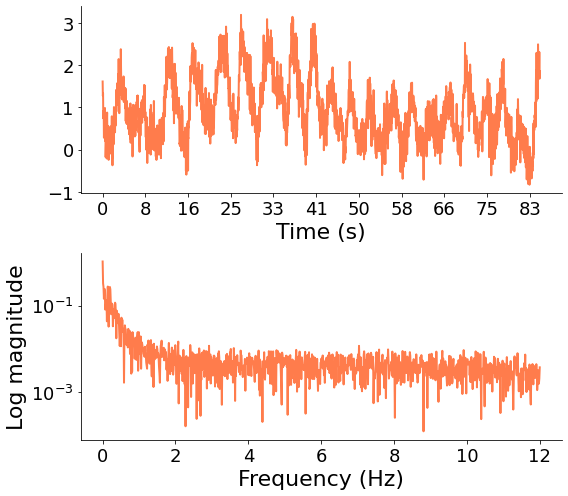

In [ ]:
plot_fft(
    fake_siganl,
    sample_rate=24,
    filename='diagrams/fake_fft.png',
    color='orangered'
)
plt.show()
plt.close()

In [ ]:
real, imag = fft.real, fft.imag
x = np.concatenate((np.expand_dims(real, axis=-1), np.expand_dims(imag, axis=-1)), axis=-1)
print(x.shape)
x_min, x_max = np.min(x), np.max(x)
x_norm = normalize(x, x_min, x_max)
print(np.min(x_norm), np.max(x_norm))

(2048, 2)
0.0 1.0


In [ ]:
x_denorm = denormalize(x_norm, x_min, x_max)
real, imag = x_denorm[:, 0], x_denorm[:, 1]
new_fft = real + imag * 1j
print(new_fft.shape, new_fft.dtype)

print(fft)
print(new_fft)
print(np.allclose(fft, new_fft, atol=0.001))

(2048,) complex64
[1080.7905   +0.j        -86.79854+324.5725j   -228.65053-158.58627j  ...
 -146.55843 -19.415096j -228.64883+158.58524j   -86.79811-324.57007j ]
[1080.7905   +0.j       -86.79855+324.5725j  -228.65054-158.58627j ...
 -146.55843 -19.4151j  -228.64883+158.58527j  -86.79811-324.57007j]
True


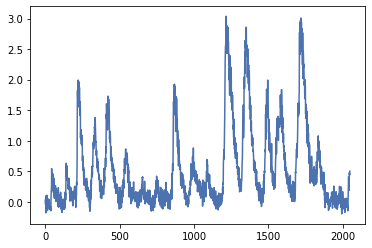

True


In [ ]:
ifft = tf.signal.ifft(new_fft)
ifft = ifft.numpy()
plt.plot(ifft.real)
plt.show()
plt.close()

print(np.allclose(ifft.real, signal, atol=0.001))

## Plot loss


In [ ]:
train_generator_loss_filename = 'diagrams/losses/train_generator_loss.csv'
train_discriminator_loss_filename = 'diagrams/losses/train_discriminator_loss.csv'
train_gradient_penatly_filename = 'diagrams/losses/train_gradient_penalty.csv'

validation_generator_loss_filename = 'diagrams/losses/validation_generator_loss.csv'
validation_discriminator_loss_filename = 'diagrams/losses/validation_discriminator_loss.csv'
validation_gradient_penatly_filename = 'diagrams/losses/validation_gradient_penalty.csv'

In [ ]:
def plot_loss(train_loss, validation_loss, ylabel='Loss', filename=None, legend=False, ylim=None,figsize=(6,4)):
  tick_size = 16
  label_size = 22
  legend_size = 18
  plt.rc('xtick', labelsize=tick_size)
  plt.rc('ytick', labelsize=tick_size)
  plt.rc('axes', titlesize=label_size)
  plt.rc('axes', labelsize=label_size)
  plt.rc('axes', labelsize=label_size)
  plt.rc('legend', fontsize=legend_size)

  plt.figure(figsize=figsize)
  plt.plot(train_loss, alpha=0.7, linewidth=3, color='dodgerblue', label='Train')
  plt.plot(validation_loss, alpha=0.7, linewidth=3, color='orangered', label='Validation')

  axis = plt.gca()
  axis.spines['top'].set_visible(False)
  axis.spines['right'].set_visible(False)

  plt.xlabel('Epoch')
  plt.ylabel(ylabel)

  plt.yticks(rotation=90)

  if ylim is not None:
    plt.ylim(ylim)

  if legend:
    plt.legend(frameon=False)

  plt.tight_layout()
  if filename is not None:
    plt.savefig(filename, dpi=200, transparent=True)

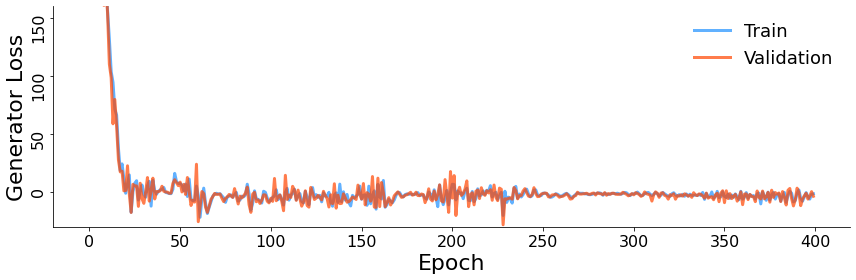

In [ ]:
train_generator_loss = pd.read_csv(train_generator_loss_filename)
validation_generator_loss = pd.read_csv(validation_generator_loss_filename)

plot_loss(
    train_generator_loss['Value'].values, 
    validation_generator_loss['Value'].values, 
    ylabel='Generator Loss', 
    filename='diagrams/losses/generator_loss.png', 
    ylim=(-30, 160),
    legend=True,
    figsize=(12, 4)
)
plt.show()
plt.close()

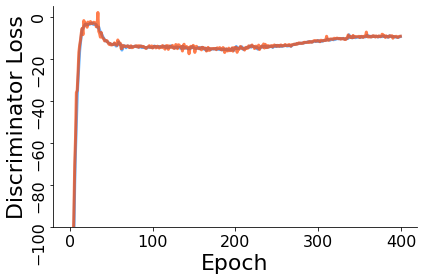

In [ ]:
train_discriminator_loss = pd.read_csv(train_discriminator_loss_filename)
validation_discriminator_loss = pd.read_csv(validation_discriminator_loss_filename)

plot_loss(
    train_discriminator_loss['Value'].values,
    validation_discriminator_loss['Value'].values,
    ylabel='Discriminator Loss',
    filename='diagrams/losses/discriminator_loss.png',
    ylim=(-100, 5)
)
plt.show()
plt.close()

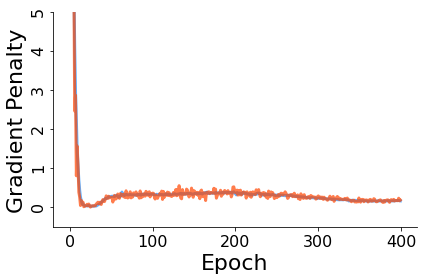

In [ ]:
train_gradient_penatly = pd.read_csv(train_gradient_penatly_filename)
validation_gradient_penatly = pd.read_csv(validation_gradient_penatly_filename)

plot_loss(
    train_gradient_penatly['Value'].values,
    validation_gradient_penatly['Value'].values,
    ylabel='Gradient Penalty',
    filename='diagrams/losses/gradient_penatly.png',
    ylim=(-.5, 5)
)
plt.show()
plt.close()

## Plot Phase Shuffle


In [ ]:
def plot_phase_shuffle(signal, filename=None):
  tick_size = 22
  label_size = 24
  plt.rc('xtick', labelsize=tick_size)
  plt.rc('ytick', labelsize=tick_size)
  plt.rc('axes', titlesize=label_size)
  plt.rc('axes', labelsize=label_size)
  plt.rc('axes', labelsize=label_size)

  x = np.arange(len(signal))

  fig, ax = plt.subplots(figsize=(10, 8))

  ax.plot(x, signal, color='darkcyan', alpha=0.7, linewidth=3)
  time = np.arange(0, len(signal), 200)
  plt.xticks(ticks=time, labels=time // 24)

  axins = ax.inset_axes([0.5, 0.5, 0.5, 0.5])
  start, end = 300, 700
  axins.plot(x[start:end], signal[start:end], color='darkcyan', alpha=0.7, linewidth=2.5)
  ax.indicate_inset_zoom(axins, linewidth=3)

  axins.set_xticklabels('')
  axins.set_xticklabels('')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.ylim((np.min(signal) - 0.2, np.max(signal) + 0.5))
  plt.xlabel('Time (s)')
  plt.ylabel(r"$\Delta F/F$")

  plt.tight_layout()
  if filename is not None:
    plt.savefig(filename, dpi=200, transparent=True)


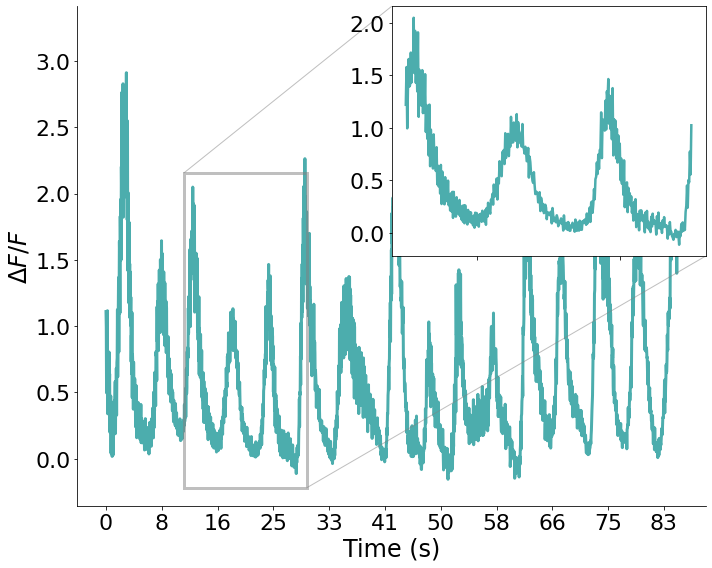

In [ ]:
no_phase_shuffle_signals = h5_helper.get('runs/ps_fix/wavegan/001_wavegan_units64_kl24_strides2_m0_leakyrelu_nd32_layernorm/generated/epoch399_signals.h5', name='signals')


plot_phase_shuffle(
    no_phase_shuffle_signals[1, :, 6],
    filename='diagrams/zoom_no_phase_shuffle.png'
)
plt.show()
plt.close()

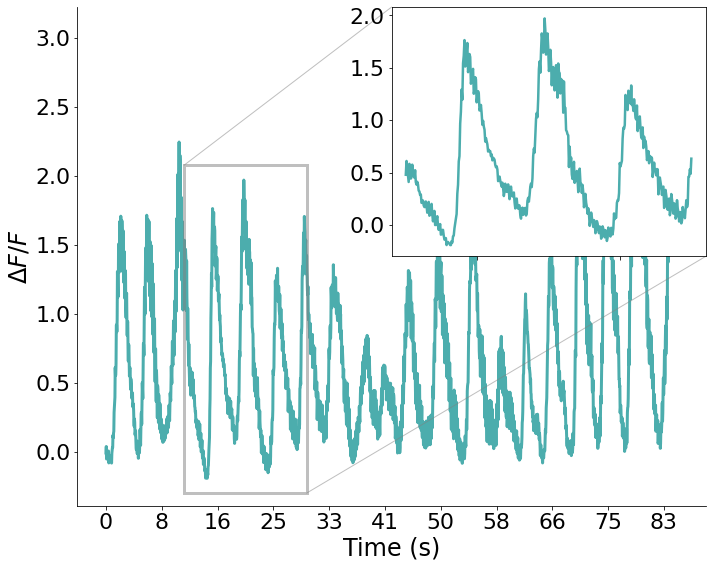

In [ ]:
phase_shuffle_signals = h5_helper.get('runs/ps_fix/wavegan/005_wavegan_units64_kl24_strides2_m10_leakyrelu_nd32_layernorm/generated/epoch499_signals.h5', name='signals')

plot_phase_shuffle(
    phase_shuffle_signals[274, :, 6],
    filename='diagrams/zoom_phase_shuffle.png'
)
plt.show()
plt.close()

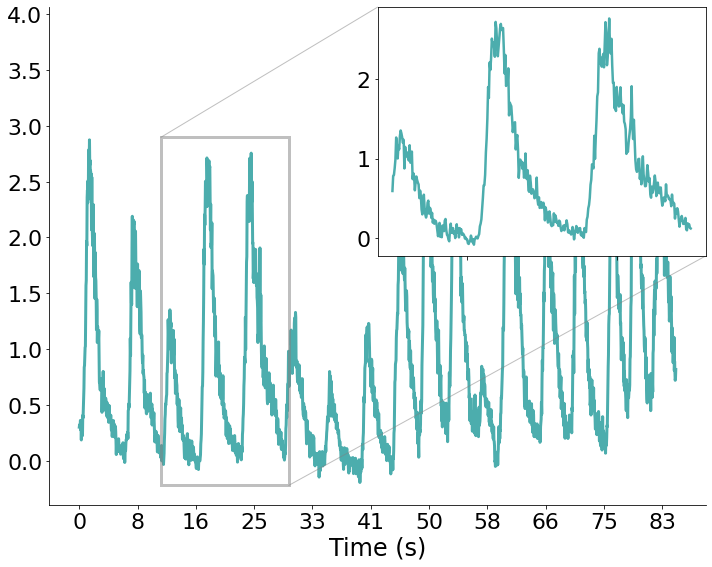

In [ ]:
real_signals = h5_helper.get('runs/ps_fix/wavegan/005_wavegan_units64_kl24_strides2_m10_leakyrelu_nd32_layernorm/generated/validation.h5', name='signals')

filename='diagrams/zoom_real_signal.png'
plot_phase_shuffle(
    real_signals[3, :, 6]
)
plt.show()
plt.close()

## Raw data information


In [ ]:
def average_firing_rate(spikes):
  neo_spikes = trains_to_neo(spikes)
  mean_firing_rates = [elephant.statistics.mean_firing_rate(neo_spike) for neo_spike in neo_spikes]
  mean_firing_rates = np.array(mean_firing_rates * pq.s, dtype=np.float32)
  return np.mean(mean_firing_rates)

def get_info(data):
  trials, times = data['trial'], data['time']

  duration = times[-1] - times[0]
  num_trials = trials[-1]
  avg_duration = duration / num_trials
  avg_firing_rate = average_firing_rate(data['spikes'][2:])
  print('Duration: {:.02f}s, Num. Trials: {:03d}, Avg. duration: {:.02f}s, Avg. firing rate: {:.02f}'.format(
      duration, num_trials, avg_duration, avg_firing_rate
  ))

In [ ]:
with open('dataset/raw_data/ST260_Day1_signals4Bryan.pkl', 'rb') as file:
  day1 = pickle.load(file)
  
get_info(day1)

Duration: 894.73s, Num. Trials: 129, Avg. duration: 6.94s, Avg. firing rate: 58.07


In [ ]:
with open('dataset/raw_data/ST260_Day4_signals4Bryan.pkl', 'rb') as file:
  day4 = pickle.load(file)
  
get_info(day4)

Duration: 898.45s, Num. Trials: 203, Avg. duration: 4.43s, Avg. firing rate: 35.83


## Phase Shuffle mechanism


In [ ]:

a = tf.random.normal((1, 5, 4), dtype=tf.float16, seed=1234)
l = a.shape[1]
print(a)
m = 0
phase = tf.random.uniform([], minval=-m, maxval=m + 1, dtype=tf.int32)
print()
print('phase: {}'.format(phase))

if phase > 0:
  paddings =[[0,0], [0, phase], [0, 0]]
  start, end = phase, l + phase
else:
  paddings = [[0,0], [abs(phase), 0], [0, 0]]
  start, end = 0, l
print()
print('paddings: {}, start: {}, end: {}'.format(paddings, start ,end))

a_padded = tf.pad(a, paddings=paddings, mode='REFLECT')
print()
print(a_padded)


crop = a_padded[:, start: end, :]
print()
print(crop)

tf.Tensor(
[[[-0.9824   1.648   -0.02818  0.83   ]
  [-0.4355  -0.3672  -0.3743  -0.887  ]
  [-0.641    0.7314   0.1462  -1.159  ]
  [ 0.728   -0.5254   0.06055  1.045  ]
  [ 1.275    1.551    0.1484  -1.401  ]]], shape=(1, 5, 4), dtype=float16)

phase: 0

paddings: [[0, 0], [<tf.Tensor: shape=(), dtype=int32, numpy=0>, 0], [0, 0]], start: 0, end: 5

tf.Tensor(
[[[-0.9824   1.648   -0.02818  0.83   ]
  [-0.4355  -0.3672  -0.3743  -0.887  ]
  [-0.641    0.7314   0.1462  -1.159  ]
  [ 0.728   -0.5254   0.06055  1.045  ]
  [ 1.275    1.551    0.1484  -1.401  ]]], shape=(1, 5, 4), dtype=float16)

tf.Tensor(
[[[-0.9824   1.648   -0.02818  0.83   ]
  [-0.4355  -0.3672  -0.3743  -0.887  ]
  [-0.641    0.7314   0.1462  -1.159  ]
  [ 0.728   -0.5254   0.06055  1.045  ]
  [ 1.275    1.551    0.1484  -1.401  ]]], shape=(1, 5, 4), dtype=float16)
